# 1. Data Setting

In [1]:
import pandas as pd

df1 = pd.read_csv("data.csv")
df2 = pd.read_csv("labels.csv")

data = df1.values
label = df2['Class']

X = data[:,1:]
y = label.ravel()
attributeNames = df1.columns[1:]
classNames = ['BRCA','KIRC','COAD','LUAD','PRAD']

# 2. Decision Tree Classifier

2.1 Find approxiametly the best number of min_samples_split

In [3]:
from sklearn import tree
from Toolbox import treeprint as tp
import pandas as pd

df1 = pd.read_csv("data.csv")
df2 = pd.read_csv("labels.csv")

data = df1.values
label = df2['Class']

attributeNames = df1.columns[1:]
classNames = ['BRCA','KIRC','COAD','LUAD','PRAD']

min_samples_split_choices = [100,150,200,250]
accuracy_dct = []

for split in min_samples_split_choices :
    dtc = tree.DecisionTreeClassifier(min_samples_split=split)
    dtc = dtc.fit(X, y)
    tp.tree_print(dtc, attributeNames, classNames)
    
    predict = [ dtc.predict([i]) for i in X ]
    original = y
    predict_original = [ (predict[i][0], original[i]) for i in range(0, len(original)) ]

    sum = 0
    for pre, org in predict_original:
        if pre == org:
            sum += 1
        
    accuracy = sum / len(predict_original)
    accuracy_dct.append(accuracy)
    print('accuracy:', accuracy)


               |->5  BRCA
               |
            |->4 then if gene_15898 =< 2.67: go to 5, else go to 6
            |  |
            |  |->6  LUAD
            |
         |->3 then if gene_3523 =< 6.32: go to 4, else go to 7
         |  |
         |  |->7  KIRC
         |
      |->2 then if gene_9176 =< 11.52: go to 3, else go to 8
      |  |
      |  |->8  PRAD
      |
   |->1 then if gene_12983 =< 9.06: go to 2, else go to 9
   |  |
   |  |  |->10  LUAD
   |  |  |
   |  |->9 else if gene_4506 =< 2.76: go to 10, else go to 11
   |     |
   |     |->11  COAD
   |
if gene_18746 =< 10.73: go to 1, else go to 12
   |
   |  |->13  PRAD
   |  |
   |->12 else if gene_513 =< 1.05: go to 13, else go to 14
      |
      |->14  BRCA
<----------------------->
Tree Depth:  5
accuracy: 1.0
            |->4  LUAD
            |
         |->3 then if gene_3523 =< 6.32: go to 4, else go to 5
         |  |
         |  |->5  KIRC
         |
      |->2 then if gene_9175 =< 7.83: go to 3, else go to 6

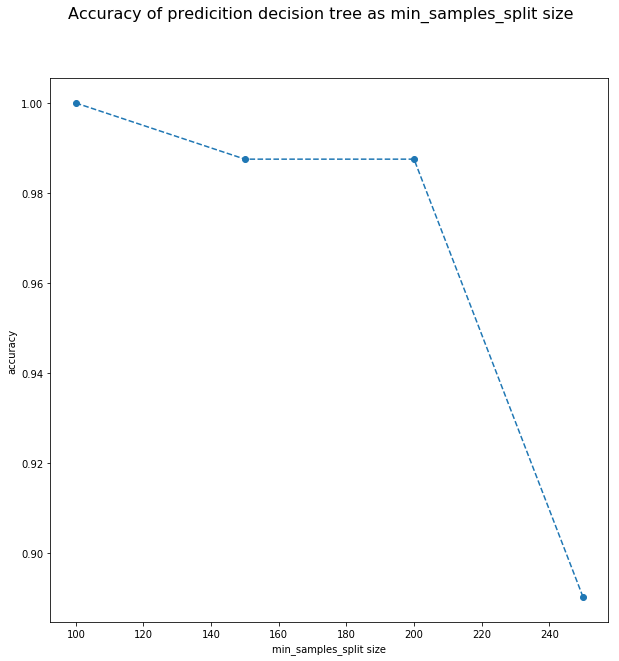

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('Accuracy of predicition decision tree as min_samples_split size', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(min_samples_split_choices, accuracy_dct, '--o' )
ax.set_xlabel('min_samples_split size')
ax.set_ylabel('accuracy')
plt.show()

2.1 Fine tune the found approxiametly best number of min_samples_split

In [7]:
min_samples_split_choices = [100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]
accuracy_dct = []

for split in min_samples_split_choices :
    dtc = tree.DecisionTreeClassifier(min_samples_split=split)
    dtc = dtc.fit(X, y)
    
    predict = [ dtc.predict([i]) for i in X ]
    original = y
    predict_original = [ (predict[i][0], original[i]) for i in range(0, len(original)) ]

    sum = 0
    for pre, org in predict_original:
        if pre == org:
            sum += 1
        
    accuracy = sum / len(predict_original)
    accuracy_dct.append(accuracy)

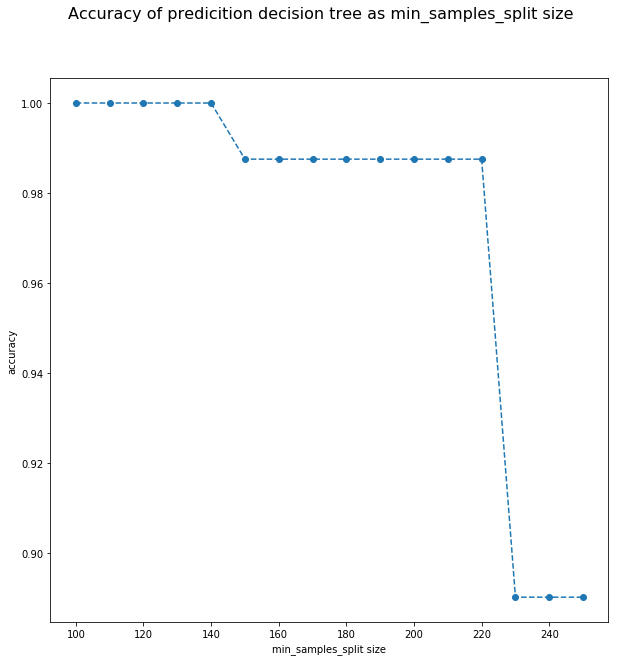

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('Accuracy of predicition decision tree as min_samples_split size', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(min_samples_split_choices, accuracy_dct, '--o' )
ax.set_xlabel('min_samples_split size')
ax.set_ylabel('accuracy')
plt.show()

As a result of splitting the sample from 100 to 250, the accuracy was highest at 100 and each tumour type in file is concuded in model. So we will use min_sample_split = 100 to analyze the data. Intersting to note is how the accuracy of the model goes down when the tree depth goes down, this will need to be investigated further. 

2.2 Find max_depth when min_samples_split=100

-- 2.2.1 Print decision tree

In [2]:
# Fit tree classifier, Gini split criterion
dtc = tree.DecisionTreeClassifier(min_samples_split=100)
dtc = dtc.fit(X, y)
tp.tree_print(dtc, attributeNames, classNames)

               |->5  BRCA
               |
            |->4 then if gene_15898 =< 2.67: go to 5, else go to 6
            |  |
            |  |->6  LUAD
            |
         |->3 then if gene_3523 =< 6.32: go to 4, else go to 7
         |  |
         |  |->7  KIRC
         |
      |->2 then if gene_9175 =< 7.83: go to 3, else go to 8
      |  |
      |  |->8  PRAD
      |
   |->1 then if gene_12983 =< 9.06: go to 2, else go to 9
   |  |
   |  |  |->10  LUAD
   |  |  |
   |  |->9 else if gene_1413 =< 8.61: go to 10, else go to 11
   |     |
   |     |->11  COAD
   |
if gene_18746 =< 10.73: go to 1, else go to 12
   |
   |  |->13  PRAD
   |  |
   |->12 else if gene_11491 =< 4.79: go to 13, else go to 14
      |
      |->14  BRCA
<----------------------->
Tree Depth:  5


The decision tree classifier identifies all kinds of labels. The max_depth = 5 when minimal_samples_split = 100. 

-- 2.2.2 Find optimal tree depth using classification error using 10-fold cross-validation (K-fold cross-validation). 

In [4]:
from sklearn.model_selection import KFold
import numpy as np

train_error_rate = [] 
test_error_rate = [] 

K = 10
kf = KFold(n_splits=K)

for depth in range(2,11):
    print(depth)
    train_depth_error = []
    test_depth_error = []

    for train_index, test_index in kf.split(X):
        # make test set
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # classification
        dtc = tree.DecisionTreeClassifier(max_depth = depth)
        dtc = dtc.fit(X_train, y_train)
        
        # check accuracy by using score(test samples, true label)
        train_error = 1 - dtc.score(X_train, y_train)
        train_depth_error.append(train_error)
        test_error = 1 - dtc.score(X_test, y_test)
        test_depth_error.append(test_error)

    train_error_rate.append(np.mean(train_depth_error))
    test_error_rate.append(np.mean(test_depth_error))
    
print(train_error_rate)
print(test_error_rate)

2
3
4
5
6
7
8
9
10
[0.2768766373863461, 0.10805998613037444, 0.010820041608876552, 0.0004160887656033285, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.2921604938271605, 0.12737654320987657, 0.032484567901234565, 0.029953703703703694, 0.026234567901234573, 0.024969135802469122, 0.02748456790123458, 0.026234567901234573, 0.022484567901234563]


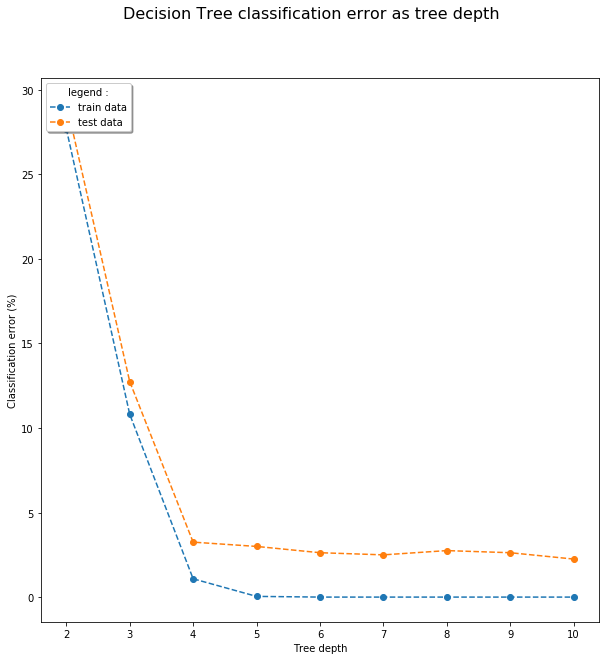

In [7]:
import matplotlib.pyplot as plt

train_error_per = [i*100 for i in train_error_rate]
test_error_per = [i*100 for i in test_error_rate]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('Decision Tree classification error as tree depth', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(range(2,11), train_error_per, '--o', label = 'train data' )
ax.plot(range(2,11), test_error_per, '--o', label = 'test data' )
ax.set_xlabel('Tree depth')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox=True)
plt.show()

It is shown that the lowest classification error rate(=0%) occurred in train data set when depth >= 5, which means that its accuracy is 100%. Therefore, the descision tree classifier to be compared with the other classifiers has the hyper-parameters min_samples_split = 100 and maximum tree_depth = 5.

# 3. K-Nearest Neighbor Classifier

3.1 Find best K-nearest neighbor classifier

-- 3.1.1 10-fold cross-validation (K-fold cross-validation)

In [10]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

train_error_rate = [] 
test_error_rate = []

for k in range(2,11):
    print(k)
    k_train_error = []
    k_test_error = []
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)

    for train_index, test_index in kf.split(X):
        # make test set 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        
        # classification
        KN = KNeighborsClassifier(n_neighbors=k)
        KN.fit(X_train, y_train)

        # check accuracy by using score(data to be tested, true label of that)
        train_error = 1 - KN.score(X_train, y_train)
        k_train_error.append(train_error)
        test_error = 1 - KN.score(X_test, y_test)
        k_test_error.append(test_error)
        
    train_error_rate.append(np.mean(k_train_error))
    test_error_rate.append(np.mean(k_test_error))
    
print(train_error_rate)
print(test_error_rate)

2
3
4
5
6
7
8
9
10
[0.0024968827930174076, 0.0012484394506866447, 0.001664586799778156, 0.0012480499219968521, 0.0014981281814182568, 0.001248266885401377, 0.0014267882616670197, 0.0014044943820224907, 0.0016647403297888718]
[0.0012468827930174342, 0.0012484394506866447, 0.0012437810945273575, 0.001242236024844723, 0.0012437810945273668, 0.0012422360248447134, 0.0012500000000000011, 0.0024968789013732895, 0.0012499999999999955]


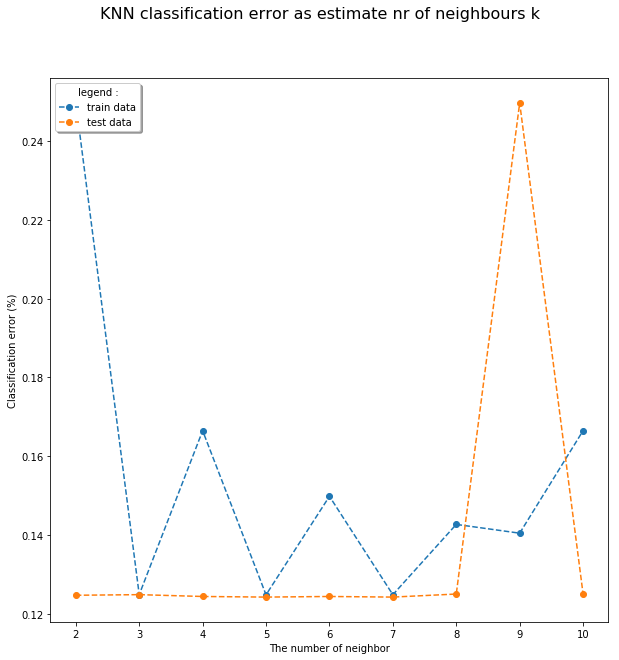

In [14]:
train_error_rate_per = [i*100 for i in train_error_rate]
test_error_rate_per = [i*100 for i in test_error_rate]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('KNN classification error as estimate nr of neighbours k', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(range(2, 11), train_error_rate_per, '--o', label = 'train data')
ax.plot(range(2, 11), test_error_rate_per, '--o', label = 'test data')
ax.set_xlabel('The number of neighbor')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox=True)
plt.show()

When the number of neighbors is 5, the error rate is the lowest in both the train set and the test set. Therefore, for 10-fold validation, set the number of neighbors to 5 for KNN classification.

Because the computation of the KNN classifier is time consuming because of the high dimensionality charachterstic of the data, the KNN classifier will use the data with a lower number of dimensions. To get the lower dimensions data, the technique Principal Component Analysis will be used. For a detail procedure and reasoning why the data is projected onto the first 300 principal components see section 7.1. principal component analysis. 

In [8]:
import numpy as np

X = X.astype(np.float64)
Y = X.copy()
mean = np.mean(X, axis = 0)
Y = X - mean

U,S,V = np.linalg.svd(Y)
VT = V.transpose()
Z = np.dot(Y, VT)

# to project data on the first 300 components
Z_2 = np.dot(Y, VT[:,0:300])


In [9]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

train_error_rate = [] 
test_error_rate = []

for k in range(2,11):
    print(k)
    k_train_error = []
    k_test_error = []
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)

    for train_index, test_index in kf.split(Z_2):
        # make test set 
        X_train, X_test = Z_2[train_index], Z_2[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        
        # classification
        KN = KNeighborsClassifier(n_neighbors=k)
        KN.fit(X_train, y_train)

        # check accuracy by using score(data to be tested, true label of that)
        train_error = 1 - KN.score(X_train, y_train)
        k_train_error.append(train_error)
        test_error = 1 - KN.score(X_test, y_test)
        k_test_error.append(test_error)
        
    train_error_rate.append(np.mean(k_train_error))
    test_error_rate.append(np.mean(k_test_error))
    
print(train_error_rate)
print(test_error_rate)

2
3
4
5
6
7
8
9
10
[0.0024968827930174076, 0.0012484394506866447, 0.001664586799778156, 0.0012480499219968521, 0.0014981281814182568, 0.001248266885401377, 0.0014267882616670197, 0.0014044943820224907, 0.0016647403297888718]
[0.0012468827930174342, 0.0012484394506866447, 0.0012437810945273575, 0.001242236024844723, 0.0012437810945273668, 0.0012422360248447134, 0.0012500000000000011, 0.0024968789013732895, 0.0012499999999999955]


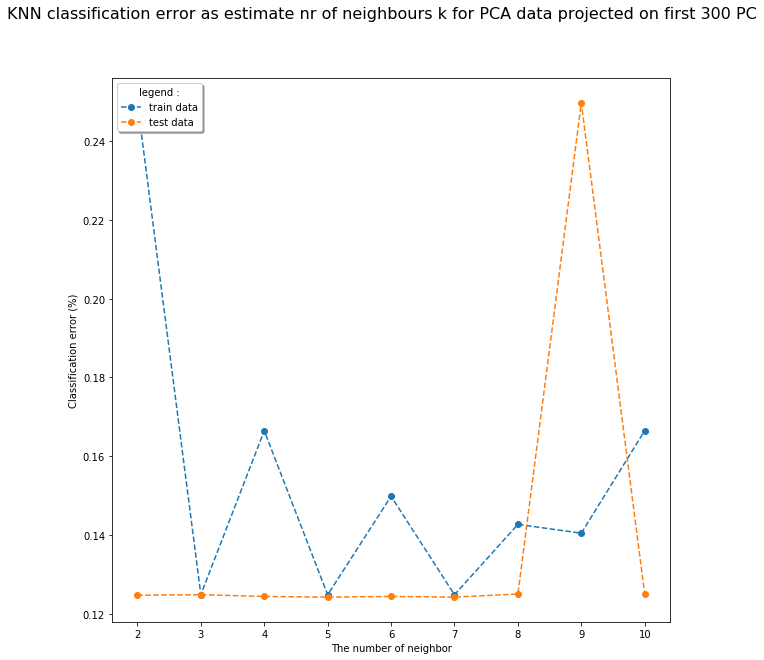

In [10]:
train_error_rate_per = [i*100 for i in train_error_rate]
test_error_rate_per = [i*100 for i in test_error_rate]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('KNN classification error as estimate nr of neighbours k for PCA data projected on first 300 PC', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(range(2, 11), train_error_rate_per, '--o', label = 'train data')
ax.plot(range(2, 11), test_error_rate_per, '--o', label = 'test data')
ax.set_xlabel('The number of neighbor')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox=True)
plt.show()

# 4. Multi-layer Perceptron Classifier

4.1 For the artificial neural network, the multi-layer perceptron classifier is used. Since the number of genes / attributes is 20531, it was chosen to have the hidden units also be 20531 to represent each gene. Since the code will not terminate if the original data is used as it is too computationally expensive, the compressed dimensional data of PCA projected onto the first 300 PAs will be used. The average classification error of the neural network of 5 learning processes will be computed for the training and test set using 10-kfold cross validation technique.

In [16]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

y= y.ravel()
K = 10
kf = KFold(n_splits = K)

error_rate = [] 

for train_index, test_index in kf.split(Z_2):
    X_train, X_test = Z_2[train_index], Z_2[test_index]
    y_train, y_test = y[train_index], y[test_index]

    k_error_rate = []
    for n in range(0,5):
        mlp_2 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20531,))
        error_list_train = []
        error_list_test = []
        mlp_2.fit(X_train, y_train)  
        y_predict = mlp_2.predict(X_test)
        error = 1 - mlp_2.score(X_test, y_test)
        k_error_rate.append(error)
        
    error_rate.append(np.mean(k_error_rate))

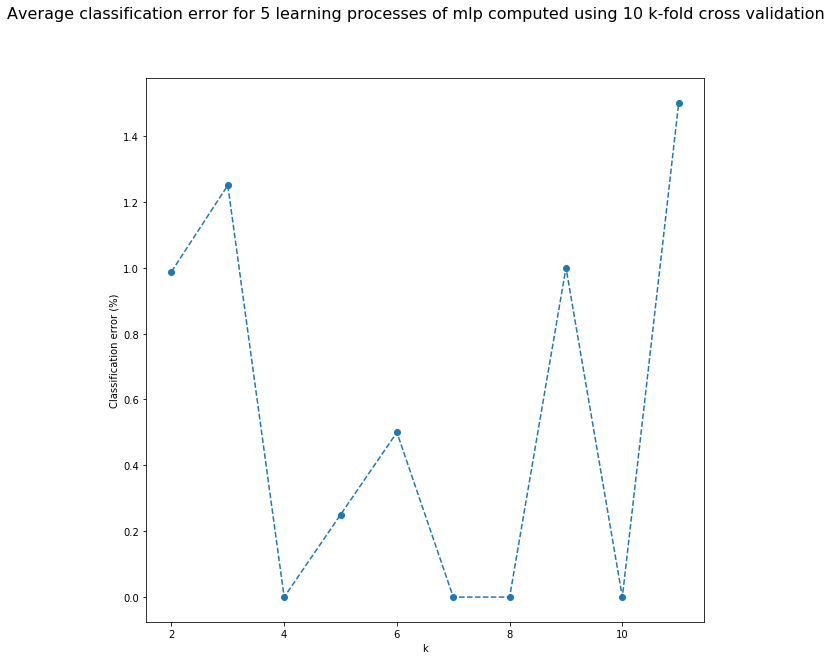

In [17]:
error_rate_per = [i*100 for i in error_rate]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('Average classification error for 5 learning processes of mlp computed using 10 k-fold cross validation', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(range(2, 12), error_rate_per, '--o')
ax.set_xlabel('k')
ax.set_ylabel('Classification error (%)')
# ax.legend(loc  = 'upper left', prop = {'size' : 10}, shadow = True, title = "legend :", fancybox = True)
plt.show()

# 5. Support Vector Machine Classifier

5.1 Find the best type of kernel

-- 5.1.1 Compare linear kernel and poly kernels

In the case of the poly scale kernel, since all of the class labels are string type, the data needs to be converted to scale data type. We will only compare the linear kernel with the poly auto kernel to decide which kernel to choose, as more fine-tuning the parameters is out of our currentt knowledge. 

In [23]:
from sklearn import svm

K = 10
kf = KFold(n_splits = K)

linear_clf = svm.SVC(kernel='linear')
poly_clf = svm.SVC(kernel='poly', gamma = 'auto')

linear_error_rate = [] 
poly_error_rate = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linear_clf = linear_clf.fit(X_train, y_train)
    poly_clf = poly_clf.fit(X_train, y_train)
    
    temp_linear_error = []
    temp_poly_error = []
        
    for n in range(0,5):
        # Returns the mean accuracy on the given test data and labels.
        # In multi-label classification, this is the subset accuracy which is a harsh metric since you require 
        # for each sample that each label set be correctly predicted.
        linear_error = 1 - linear_clf.score(X_test, y_test) 
        temp_linear_error.append(linear_error)
        
        poly_error = 1 - poly_clf.score(X_test, y_test) 
        temp_poly_error.append(poly_error)
        
    linear_error_rate.append(np.mean(temp_linear_error))
    poly_error_rate.append(np.mean(temp_poly_error))
    
print(linear_error_rate)
print(poly_error_rate)

[0.0, 0.012499999999999956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.012499999999999956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


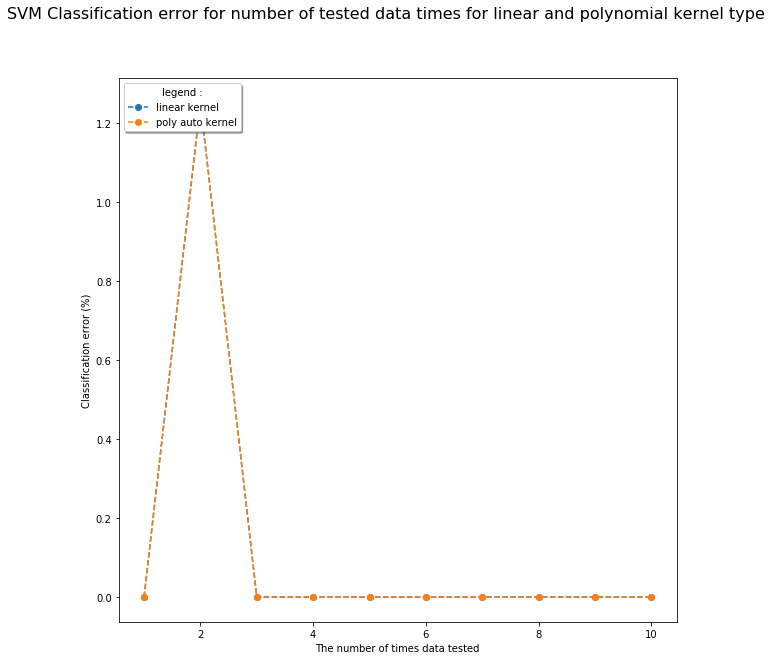

In [26]:
linear_error__per = [i*100 for i in linear_error_rate]
poly_error__per = [i*100 for i in poly_error_rate]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('SVM Classification error for number of tested data times for linear and polynomial kernel type ', fontsize = 16)
ax = plt.subplot(1,1, 1)
ax.plot(range(1, 11), linear_error__per, '--o', label='linear kernel')
ax.plot(range(1, 11), poly_error__per, '--o', label='poly auto kernel')
ax.set_xlabel('The number of times data tested')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox=True)
plt.show()

Since both types of kernels return exactly the same value, it appears to do the same thing regardless of the kernel type. In other words, choosing the kernel type has no effect on the results of our data set.

# 6. Compare the accuracy depending on the type of Classifier 

6.1 Make a graph with error rate of DCT, KNN, MLP and SVM

In previous tests, for k-fold cross validation, the optimal hyper-parameters was found to provide maximum accuracy for each classifier when k = 10. Use these optimal hyper para-meters to define a new classifier and check the error rate five times for each train set and test set created by validation. The average error rate is returned for each data set. Then draw a graph with all the classifications to determine the most accurate classifier (low error rate). The ideal code is to create train sets and test sets through cross validation and then test all of the classification criteria at once. This method is more reliable than comparing measured accuracies because it uses exactly the same data set when it comes to classification. However, using multiple classifiers at once to train a train set and calculate its accuracy requires too much memory for normal computers. Since the code crashed twice, we decided to split the classifier up. This allows different train sets and test sets to be used for each verification. Because test is repeated several times, the data is considered to be evenly splited, so it is possible to compare the classification functions. However for the MLP classifier the code crashed each time as it is so computationally heavy, in order to preserve our computers we decided not to graph the 10-kfold cross validation of MLP.

In [12]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np

K = 10
kf = KFold(n_splits=K)

In [13]:
# classification - DCT
dtc = tree.DecisionTreeClassifier(min_samples_split=100, max_depth=5)
# classification - KNN
KN = KNeighborsClassifier(n_neighbors=5)

dct_error_rate = [] 
knn_error_rate = []

for train_index, test_index in kf.split(X):
    # make train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    temp_dct_error = []
    temp_knn_error = []
    temp_mlp_error = []
    
    for test in range(0,5):
        # fit train data set
        dtc = dtc.fit(X_train, y_train)
        KN = KN.fit(X_train, y_train)
    
        # check accuracy by using score(test samples, true label)
        dct_error = 1 - dtc.score(X_test, y_test)
        temp_dct_error.append(dct_error)
        knn_error = 1 - KN.score(X_test, y_test)
        temp_knn_error.append(knn_error)
    
    dct_error_rate.append(np.mean(temp_dct_error))
    knn_error_rate.append(np.mean(temp_knn_error))
    
print(dct_error_rate)
print(knn_error_rate)

[0.01975308641975313, 0.012499999999999956, 0.03749999999999998, 0.002499999999999991, 0.025000000000000022, 0.004999999999999982, 0.03500000000000001, 0.022499999999999985, 0.019999999999999973, 0.07749999999999999]
[0.0, 0.012499999999999956, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


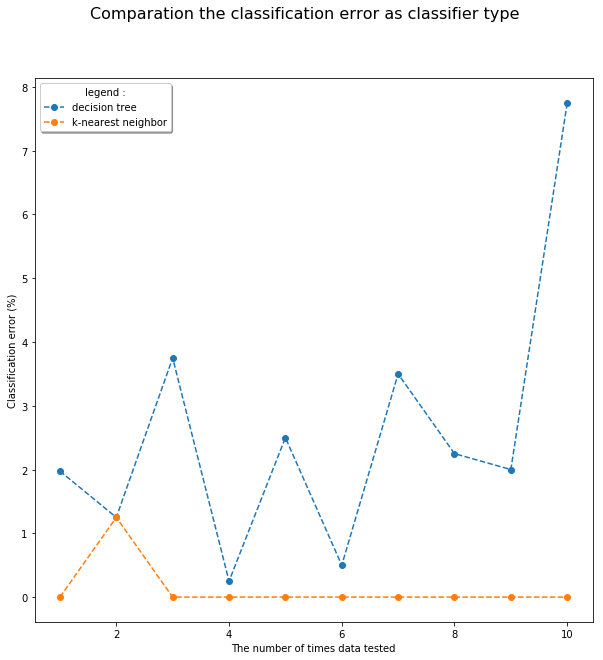

In [14]:
dct_error_rate_per = [i*100 for i in dct_error_rate]
knn_error_rate_per = [i*100 for i in knn_error_rate]

fig = plt.figure(1, figsize=(10,10))
fig.suptitle('Comparation the classification error as classifier type', fontsize=16)
ax = plt.subplot(1,1,1)
ax.plot(range(1,11), dct_error_rate_per, '--o', label='decision tree')
ax.plot(range(1,11), knn_error_rate_per, '--o', label='k-nearest neighbor')
ax.set_xlabel('The number of times data tested')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox = True)
plt.show()

In [ ]:
# classification - DCT
dtc = tree.DecisionTreeClassifier(min_samples_split=100, max_depth=5)
# classification - KNN
KN = KNeighborsClassifier(n_neighbors=5)
# classification - SVC linear
linear_clf = svm.SVC(kernel='linear')

dct_error_rate = [] 
knn_error_rate = []
clf_error_rate = []

for train_index, test_index in kf.split(X):
    # make train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    temp_dct_error = []
    temp_knn_error = []
    temp_mlp_error = []
    temp_clf_error = []
    
    for test in range(0,5):
        # fit train data set
        dtc = dtc.fit(X_train, y_train)
        KN = KN.fit(X_train, y_train)
        clfl = linear_clf.fit(X_train, y_train)
    
        # check accuracy by using score(test samples, true label)
        dct_error = 1 - dtc.score(X_test, y_test)
        temp_dct_error.append(dct_error)
        knn_error = 1 - KN.score(X_test, y_test)
        temp_knn_error.append(knn_error)
        clf_error = 1 - linear_clf.score(X_test, y_test) 
        temp_clf_error.append(clf_error)
    
    dct_error_rate.append(np.mean(temp_dct_error))
    knn_error_rate.append(np.mean(temp_knn_error))
    clf_error_rate.append(np.mean(temp_clf_error))

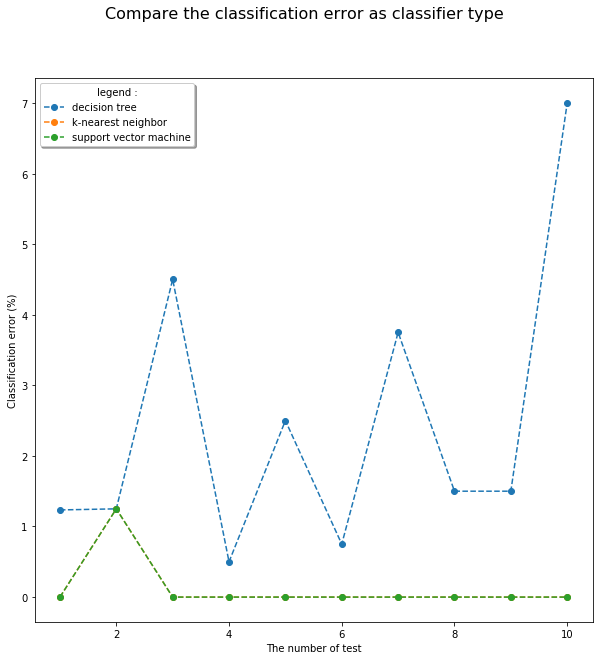

In [73]:
dct_error_rate_per = [i*100 for i in dct_error_rate]
knn_error_rate_per = [i*100 for i in knn_error_rate]
clf_error_rate_per = [i*100 for i in clf_error_rate]

fig = plt.figure(1, figsize=(10,10))
fig.suptitle('Compare the classification error as classifier type', fontsize=16)
ax = plt.subplot(1,1,1)
ax.plot(range(1,11), dct_error_rate_per, '--o', label='decision tree')
ax.plot(range(1,11), knn_error_rate_per, '--o', label='k-nearest neighbor')
ax.plot(range(1,11), mlp_error_rate_per, '--o', label='multi-layer perceptron')
ax.plot(range(1,11), clf_error_rate_per, '--o', label='support vector machine')
ax.set_xlabel('The number of test')
ax.set_ylabel('Classification error (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox = True)
plt.show()

When we tested each data set made with K-fold, we got the above results. KNN and SVM showed similar error rates, and DCT had slightly higher error rates than the other two. Therefore, the optimal classifier is considered KNN. However, the error rate difference between DCT and KNN is not noticeably large, and it may be more useful to use DCT for feature selection.

# 7. Data Analysis

7.1 Principle Component Analysis (PCA) 

In [10]:
X = X [:,1:]
X = X.astype(np.float64)
Y = X.copy()
mean = np.mean(X, axis = 0)
Y = X - mean

U,S,V = np.linalg.svd(Y)
VT = V.transpose()
Z = np.dot(Y, VT)

# Variance of the first 20 PCs. 
sum = np.sum(Z ** 2, axis = 0)
total = np.sum(sum) 
Var = sum  / total
print(Var[0:20])

[0.15838558 0.10503965 0.09472226 0.06500807 0.0361562  0.02972669
 0.02657144 0.01562732 0.01407074 0.01226874 0.00960111 0.0089022
 0.00758206 0.00723022 0.00664002 0.00637714 0.00569485 0.00517577
 0.00462122 0.00445512]


To calculate how much of the variance of the total variance of the model is explained by the first 3 PC and the first 4 PC. 

In [14]:
PCT = Var[0] + Var[1] + Var[2]
Tot = np.sum(Var)
Per = PCT / Tot * 100
print(Per)

PCT_2 = Var[0] + Var[1] + Var[2] + Var[3]
Tot = np.sum(Var)
Per_2 = PCT_2 / Tot * 100
print(Per_2)

35.81474917338711
42.31555575859674


To graph the explained variance of the total as the number of components :

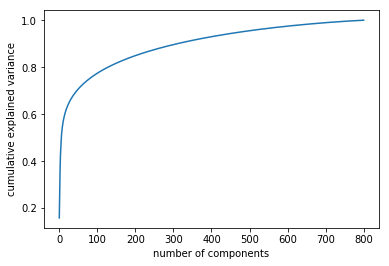

In [5]:
import sklearn.datasets as ds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

From the graph it can be seen that around 90 % of the variance can be explained from the first 300 Princinpal Components. To examine this further, we create 2 graphs : the explained variance of the first 10 PC and the explained variance of the first 300 PC. 

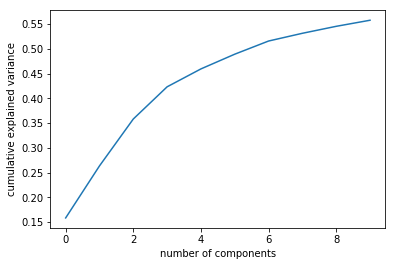

In [18]:
pca = PCA(10).fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

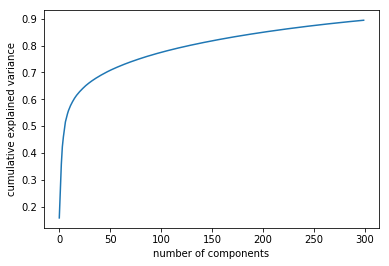

In [19]:
pca = PCA(300).fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
# to keep 90 % of the variance, around 300 components are needed

/Users/Kimnayeong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


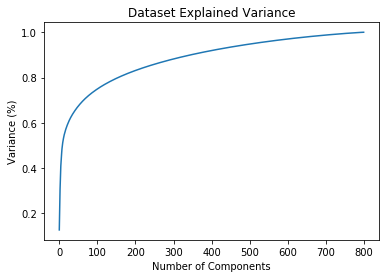

In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X[1:, 0:20531])

pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

7.2 Feature Selection

-- 7.2.1 Check feature selection (genes) 

Construct a tree classifier using min_samples_split and max_depth to find the gene that represents a particular cancer. See the tree repeatedly to find three genes with the highest probability which can be criteria causing specific cancer.

In [ ]:
data = df1.values
label = df2['Class']

X = data[:,1:]
y = label.ravel()

for i in range(0,10):
    dtc = tree.DecisionTreeClassifier(min_samples_split=100, max_depth=5)
    dtc = dtc.fit(X, y)
    tp.tree_print(dtc, attributeNames, classNames)

In the 10 trees, gene_18746, gene_12983 and gene_3523 always appear as classification criteria. Therefore, these genes can be used as features in cancer classification.

-- 7.2.2 Predict model

In [13]:
# gene selectin model
# most frequent genes used in decesion trees
Freq_Genes = X[:, [18746, 12983, 3523]]
dtc = tree.DecisionTreeClassifier(min_samples_split=100, max_depth=5)
dtc = dtc.fit(Freq_Genes, y)
tp.tree_print(dtc, attributeNames, classNames)

               |->5  PRAD
               |
            |->4 then if gene_0 =< 8.45: go to 5, else go to 6
            |  |
            |  |->6  PRAD
            |
         |->3 then if gene_2 =< 1.55: go to 4, else go to 7
         |  |
         |  |  |->8  LUAD
         |  |  |
         |  |->7 else if gene_0 =< 8.75: go to 8, else go to 9
         |     |
         |     |->9  PRAD
         |
      |->2 then if gene_2 =< 6.32: go to 3, else go to 10
      |  |
      |  |->10  KIRC
      |
   |->1 then if gene_1 =< 9.06: go to 2, else go to 11
   |  |
   |  |  |->12  COAD
   |  |  |
   |  |->11 else if gene_1 =< 9.62: go to 12, else go to 13
   |     |
   |     |->13  COAD
   |
if gene_0 =< 10.73: go to 1, else go to 14
   |
   |  |->15  BRCA
   |  |
   |->14 else if gene_0 =< 10.93: go to 15, else go to 16
      |
      |->16  BRCA
<----------------------->
Tree Depth:  5


In [ ]:
-- 7.2.3 Check model

In [14]:
# tree pruning using 10-fold cross-validation(K-fold cross-validation)

from sklearn.model_selection import KFold
import numpy as np

accuracy1 = []
accuracy2 = []

K = 10
kf = KFold(n_splits=K)

for train_index, test_index in kf.split(Freq_Genes):
    test_accuracy1 = []
    test_accuracy2 = []
    
    # make test set
    X_train, X_test = Freq_Genes[train_index], Freq_Genes[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for test in range(0,10):
        # classification - DCT
        dtc = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=100)
        dtc = dtc.fit(X_train, y_train)
        # classification - KNN
        KN = KNeighborsClassifier(n_neighbors=5)
        KN = KN.fit(X_train, y_train)
        
        # check accuracy by using score(test samples, true label)
        test_accuracy1.append(dtc.score(X_test, y_test))
        test_accuracy2.append(KN.score(X_test, y_test))

    accuracy1.append(np.mean(test_accuracy1))
    accuracy2.append(np.mean(test_accuracy2))

print(accuracy1)
print(accuracy2)

[0.888888888888889, 0.85, 0.8875, 0.9125, 0.9, 0.8875, 0.8875, 0.875, 0.9125, 0.85]
[0.9382716049382717, 0.9250000000000002, 0.9625, 0.9, 0.9499999999999998, 0.9499999999999998, 0.9375, 0.8875, 0.9499999999999998, 0.8875]


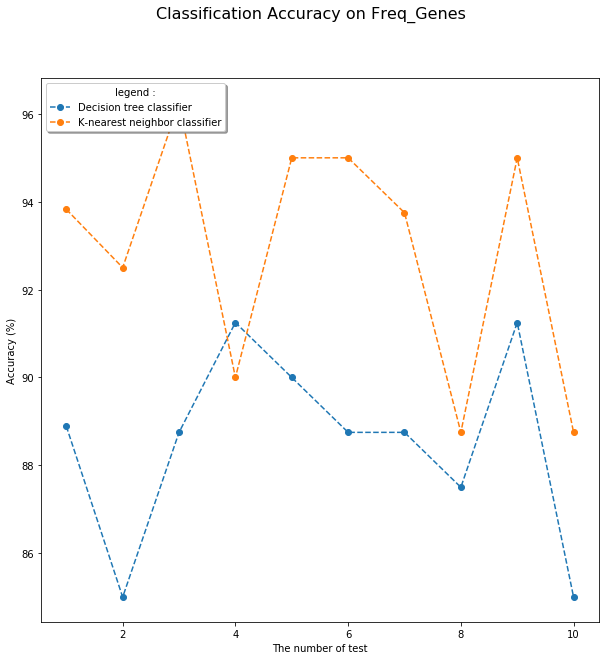

In [15]:
accuracy_per1 = [i*100 for i in accuracy1]
accuracy_per2 = [i*100 for i in accuracy2]

fig = plt.figure(1, figsize = (10,10))
fig.suptitle('Classification Accuracy on Freq_Genes', fontsize = 16)
ax = plt.subplot(1,1,1)
ax.plot(range(1,11), accuracy_per1, '--o', label = 'Decision tree classifier' )
ax.plot(range(1,11), accuracy_per2, '--o', label = 'K-nearest neighbor classifier' )
ax.set_xlabel('The number of test')
ax.set_ylabel('Accuracy (%)')
ax.legend(loc='upper left', prop={'size' : 10}, shadow=True, title="legend :", fancybox = True)
plt.show()

In [ ]:
# tree pruning using 10-fold cross-validation(K-fold cross-validation)

from sklearn.model_selection import KFold
import numpy as np

accuracy1 = []
accuracy2 = []

K = 10
kf = KFold(n_splits=K)

for train_index, test_index in kf.split(Freq_Genes):
    test_accuracy1 = []
    
    # make test set
    X_train, X_test = Freq_Genes[train_index], Freq_Genes[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for test in range(0,10):
        # classification - KNN
        KN = KNeighborsClassifier(n_neighbors=5)
        KN = KN.fit(X_train, y_train)
        
        # check accuracy by using score(test samples, true label)
        test_accuracy1.append(KN.score(X_test, y_test))
        
    accuracy1.append(np.mean(test_accuracy1))
    
for train_index, test_index in kf.split(Z_3: ):
    test_accuracy1 = []
    
    # make test set
    X_train, X_test = Freq_Genes[train_index], Freq_Genes[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for test in range(0,10):
        # classification - KNN
        KN = KNeighborsClassifier(n_neighbors=5)
        KN = KN.fit(X_train, y_train)
        
        # check accuracy by using score(test samples, true label)
        test_accuracy1.append(KN.score(X_test, y_test))
    accuracy2.append(np.mean(test_accuracy2))
    
     test_accuracy2 = []

print(accuracy1)
print(accuracy2)